## Introduction 

First we just install all dependencies that we need. Wrapping these dependencies in a function ensures that the notebook environment is reproducible and that packages are automatically installed without the user having to worry about doing this manually.

In [1]:
# Check if all dependencies are installed and if not install them
install_dependencies <- function(dependencies){
    
    installed <- installed.packages()[,"Package"]
    
    to_install <- dependencies[!(dependencies %in% installed)]
    
    if(length(to_install) > 0){install.packages(to_install)}
    
    sapply(dependencies, require, character.only = TRUE)
    
 
}

# Specify the dependencies here
dependencies <- c("tidyverse")

data_path <- './data/01_data.csv'

install_dependencies(dependencies)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



tidyverse 
     TRUE

## Data Loading and Cleaning

Now we are ready to load the data. This function takes as input the path to the .csv file which holds the data and returns a tibble object containing the data.

In [2]:
# Load data
load_data <- function(data_path){
    
    df <- read_csv(data_path)
    
    return(df)
}

df <- load_data(data_path)


── Column specification ────────────────────────────────────────────────────────
cols(
  `Type 1` = col_double(),
  `Type 2` = col_double()
)




The data as given is not in the appropriate format to run all our data analysis. In particular we have two columns in the data: Type 1 and Type 2. To be able to run the linear regression model using the specification given below we reformat the dataset to unite these two columns into one column called 'outcome.' Then we add a dummy variable column called 'type' which takes the value 1 for Type 1 rows and 0 for Type 2 rows respectively.

In [3]:
# Label group variable in data
label_groups <- function(df){
    
    type_1 <- select(df, "Type 1") %>% mutate(., "type" = 1) %>% rename(., outcome = `Type 1`)
    
    type_2 <- select(df, "Type 2") %>% mutate(., "type" = 0) %>% rename(., outcome = `Type 2`)
    
    type_1$type <- as.factor(type_1$type)
    
    type_2$type <- as.factor(type_2$type)
    
    df_clean <- bind_rows(type_1, type_2)
    
    return(df_clean)
    
}

df_clean <- label_groups(df)

## Data Analysis

### Linear model

Now we are finally able to run our data analysis. The function given below runs a simple linear regression with the following specification: 

 - $Y = X\beta + \epsilon$

The model assumptions are also given below: 

 - ${(X^TX)}^{-1}$ is full rank


 - $\epsilon \sim N(0,V)$
 

In [4]:
# Run linear model
run_linear_model <- function(df){
    
    model <- lm(outcome ~ type, data = df)
    
    return(model)
    
}

df_linear <- run_linear_model(df_clean)

summary(df_linear)


Call:
lm(formula = outcome ~ type, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-7.603 -2.333 -1.323  3.109  6.207 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   10.633      1.348   7.888 2.99e-07 ***
type0         -3.883      1.906  -2.037   0.0566 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.263 on 18 degrees of freedom
Multiple R-squared:  0.1873,	Adjusted R-squared:  0.1422 
F-statistic: 4.149 on 1 and 18 DF,  p-value: 0.05664


Before we get into the interpretation of the resulting test we derive it analytically. Taking expectations of the linear regression model above on both sides we get:

- $E(Y|X = 1) = \beta_{0} + \beta_{1}$


- $E(Y|X = 0) = \beta_{0}$


- $E(Y|X = 1) - E(Y|X=0) = \beta_{1}$

Our question in English is: are the means of the two groups different? From the above this is the same as doing the following test: 

- $H_{0}: \beta_{1} = 0 \quad vs \quad H_{A}: \beta_{1} \neq 0$

To do this hypothesis test this we need the distribution of an easily calculable statistic of $\beta_{1}^{OLS}$ under $H_0$ with repeated sampling. We can derive this as follows: 

$$
\begin{align}
\beta_1^{OLS, H_0} \sim N( \beta_{1}^{H_0}, (X^TX)^{-1}_{11}\sigma^{2})
 \implies \frac{\beta_1^{OLS, H_0}}{(X^TX)^{-1/2}_{11}\sigma} \sim N(0,1)
\end{align}
$$

However, calculating this statistic and hence using this sampling distribution is not feasible as $\sigma$ is not known for the population. We instead consider estimating this $\sigma$ using the data we have. Consider the following: 

$$
\begin{align}
\frac{\epsilon^{OLS,T}\epsilon^{OLS}}{\sigma^2} \sim \chi^{2}(n-2)
\end{align}
$$

We already know that for $X \sim N(0,1)$ and $Y \sim \chi^{2}(n-p)$ that $\frac{X}{\sqrt{Y}} \sim t_{(n-p)}.$ We use this result by substituting the above form into the test to get rid of the unknown $\sigma^{2}$ as follows: 

$$
\begin{align}
\frac{\beta_1^{OLS, H_0}}{\chi_{n-2}} \sim t_{n-2}
\end{align}
$$


We observe from the results that the difference in sample means is approximately 3.883. The standard error is 1.906. This is a measure of average deviance from the mean. Linear regression returns a p-value of 0.0566. We fail to reject $H_{0} = 0$ at the conventional 5% and more stringent 1% level. This means that given the null hypothesis of no difference in means is true there is a slightly greater than 5% probability that we would observe a difference in sample means as or more extreme than 3.8333.

### Diagnostics

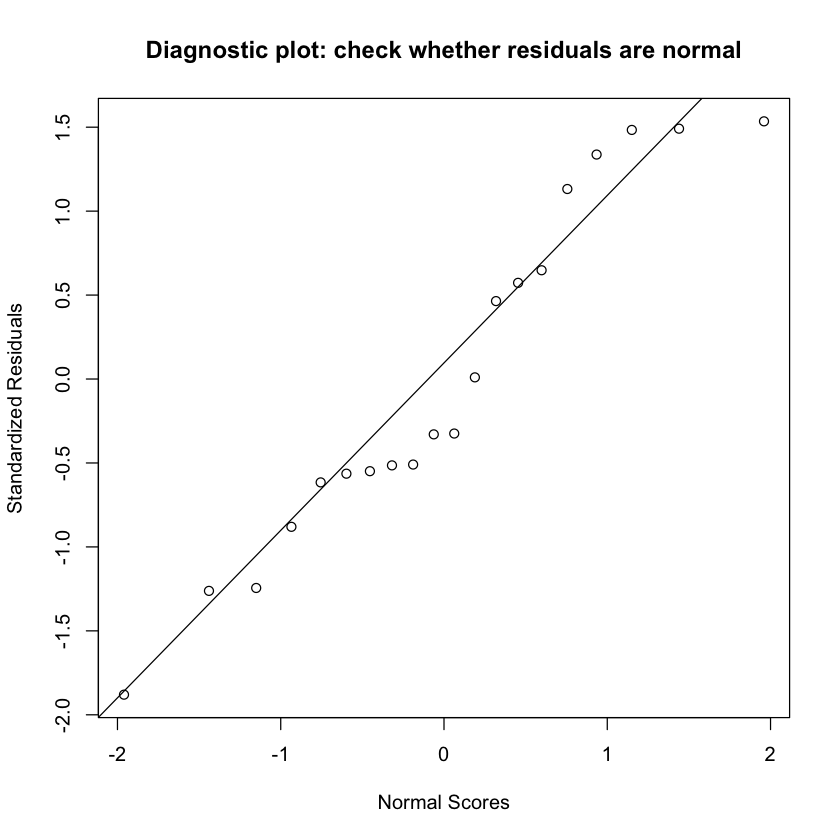

In [5]:
# Check model assumptions
check_normal_residuals <- function(model){
    
    stdres = rstandard(model)
    
    qqnorm(stdres, 
           ylab="Standardized Residuals", 
           xlab="Normal Scores", 
           main="Diagnostic plot: check whether residuals are normal") 
    
    qqline(stdres)
     
}

check_normal_residuals(df_linear)

How much should we trust these results? We can run diagnostic checks on our linear regression model to see whether there is evidence that any of the underlying assumptions are violated. The first diagnostic we do is a q-q plot. We standardize the residuals. This means that we divide the residuals by their estimated standard deviations. We then expect these standardized residuals to follow a standard normal $N(0,1)$ distribution. Next we plot the quantiles of a hypothetical normal distribution along with the quantiles of our observed distribution. If the normality assumption holds then the dots denoting the residuals should lie along this line. However in our plot above this does not seem to be the case particularly close to 0.

## Two-sample t-test

We run the regular two-sample t-test using the t-test command with variance equal to true to demonstrate that this is equal to running the linear regression.

In [6]:
# This is a two sample t-test assuming variances are equal
run_two_sample_t_test <- function(df, var){
    
    return(t.test(select(df, `Type 1`), select(df, `Type 2`), var = var))
    
}

df_ttest <- run_two_sample_t_test(df, var = TRUE)

df_ttest


	Two Sample t-test

data:  select(df, `Type 1`) and select(df, `Type 2`)
t = 2.0369, df = 18, p-value = 0.05664
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1221128  7.8881128
sample estimates:
mean of x mean of y 
   10.633     6.750 


Note that the values are the same, indicating that running the regression is equivalent to running the two-sample t-test. One hidden assumption here that we note is that the maintained hypothesis is equal variances across both types. To see how whether this assumption holds in our sample we draw boxplots to understand the distributions of outcomes across types. As we can see below, the equal variance assumption does not seem to hold.

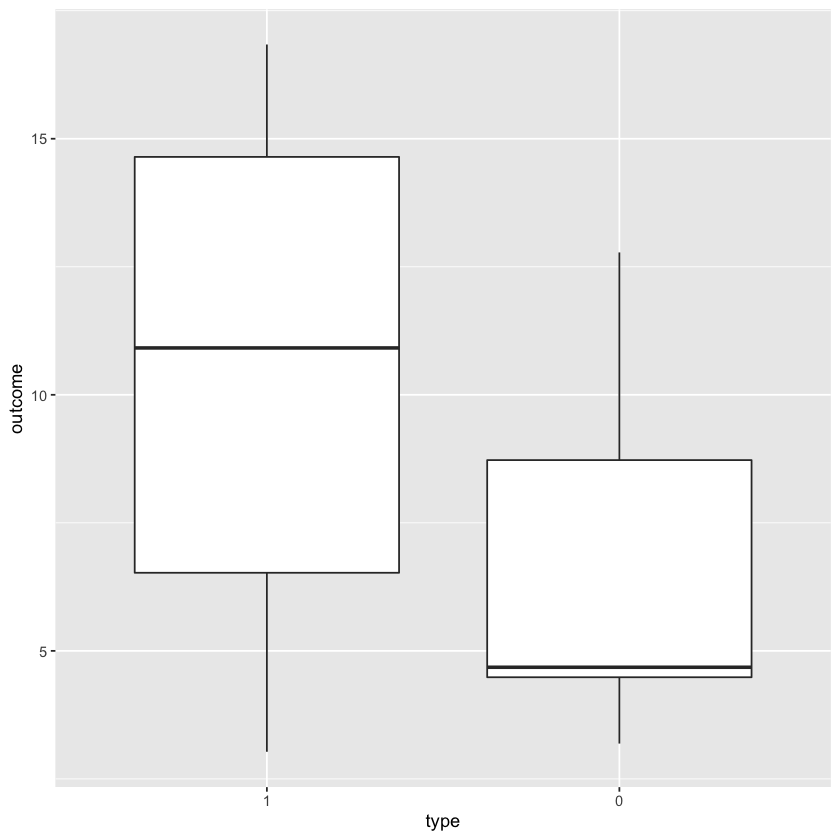

In [7]:
# We check the equal variance assumption by making boxplots of the two distributions
check_equal_variances <- function(df){
    
    p <- ggplot(df, aes(x=type, y=outcome)) + geom_boxplot()
    
    return(p)
    
}

check_equal_variances(df_clean)

To mitigate this we perform a more general t-test which does not assume equal variances below. The resulting p-value is very similar to the p-value from the test which used the pooled variance. We still fail to reject $H_0 = 0$ at conventional significance thresholds. 

In [8]:
df_ttest_unequal_var <- run_two_sample_t_test(df, var = FALSE)

df_ttest_unequal_var


	Welch Two Sample t-test

data:  select(df, `Type 1`) and select(df, `Type 2`)
t = 2.0369, df = 16.641, p-value = 0.0579
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.145694  7.911694
sample estimates:
mean of x mean of y 
   10.633     6.750 


We also perform a non-parametric Wilcoxon rank test. This test is distribution free. The downside is that it works only for large $n$. However, it

In [9]:
non_parametric_test <- function(df){    

    return(wilcox.test(`outcome` ~ `type`, data=df))
}

non_parametric_test(df_clean)


	Wilcoxon rank sum exact test

data:  outcome by type
W = 74, p-value = 0.07526
alternative hypothesis: true location shift is not equal to 0
